In [1]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial
from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt
# Switch off the cache 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv ('csv_result-phpMawTba 2.csv',na_values='?')   
df = pd.DataFrame(data)
df.info()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              48842 non-null  int64 
 1   age             48842 non-null  int64 
 2   workclass       46043 non-null  object
 3   fnlwgt          48842 non-null  int64 
 4   education       48842 non-null  object
 5   education-num   48842 non-null  int64 
 6   marital-status  48842 non-null  object
 7   occupation      46033 non-null  object
 8   relationship    48842 non-null  object
 9   race            48842 non-null  object
 10  sex             48842 non-null  object
 11  capital-gain    48842 non-null  int64 
 12  capital-loss    48842 non-null  int64 
 13  hours-per-week  48842 non-null  int64 
 14  native-country  47985 non-null  object
 15  class           48842 non-null  object
dtypes: int64(7), object(9)
memory usage: 6.0+ MB


We clean our data
=======================

In [14]:
#first let's see a sample of our data
print(df.head(10))

    id  age         workclass  fnlwgt     education  education-num  \
0    1   25           Private  226802          11th              7   
1    2   38           Private   89814       HS-grad              9   
2    3   28         Local-gov  336951    Assoc-acdm             12   
3    4   44           Private  160323  Some-college             10   
5    6   34           Private  198693          10th              6   
7    8   63  Self-emp-not-inc  104626   Prof-school             15   
8    9   24           Private  369667  Some-college             10   
9   10   55           Private  104996       7th-8th              4   
10  11   65           Private  184454       HS-grad              9   
11  12   36       Federal-gov  212465     Bachelors             13   

        marital-status         occupation   relationship   race     sex  \
0        Never-married  Machine-op-inspct      Own-child  Black    Male   
1   Married-civ-spouse    Farming-fishing        Husband  White    Male   
2   

In [ ]:

#from the last print we see that the missing values are labeled with the symbol '?'
#so we remove the values with this symbol '?:
df=df.dropna()



#we separate the categorical variables one-hot encoding
df_categorical=df[['workclass','education','marital-status','occupation','relationship','race','sex','native-country']]

#we separate the columns with numerical values
#checking by hand the significance of our columns we see that we have redundant columns so we keep only the relevant ones
df_numerical=df[['age','education-num','capital-gain','capital-loss','hours-per-week']]

columnas=["age","education-num","capital-gain","capital-loss","hours-per-week"]
for j in columnas:
    df_numerical[j] = df_numerical[j] /df_numerical[j].abs().max()

#and finally we split our data into two classes, people who earn less or equal that 50k and more than 50k
df.loc[df["class"] == "<=50K", "class"] = 1
df.loc[df["class"] == ">50K", "class"] = -1




We perform a one hot encoder from scratch using pandas just for fun
====================================================================

In [5]:

renglones=df['race'].shape[0]
columnas=df_categorical.shape[1]
one_hot=np.zeros(renglones)

col=0
df2=pd.DataFrame()
df3=pd.DataFrame()
df3.insert(0,'1',one_hot)
for k in range(0,columnas):
    name=df_categorical.columns[k]
    #print(name)
    lista=[]
    lista=df_categorical[name].values.tolist()
    clases=df_categorical[name].unique() #an array of our different classes
    size_clases=len(clases)
    
    
    for i in range(size_clases):
        clase=clases[i]
        #print(clase)

        for j in range(0,renglones):
            if lista[j]==clase:
                one_hot[j]=1  
        
        df2.insert(i,clase,one_hot)
        
        one_hot=np.zeros(renglones)
    df3=df3.join(df2)
    df2=pd.DataFrame()


df3.to_csv('one_hot.csv')

And finally we concatenate and save into a final .csv file
=================================================================

In [16]:
df_clase=df['class']
df_clase=df_clase.reset_index()
df_clase=df_clase.drop(['index'],axis=1)

df_numerical=df_numerical.reset_index()
df_numerical=df_numerical.drop(['index'],axis=1)
print('este es el dataframe numerico',df_numerical)
df3=df3.reset_index()
frames=[df_clase,df_numerical,df3]

df_final=pd.concat(frames,axis=1)
df_final=df_final.drop(['index'],axis=1)
print(df_final.shape)   

df_final.to_csv('final.csv')


este es el dataframe numerico             age  education-num  capital-gain  capital-loss  hours-per-week
0      0.277778         0.4375      0.000000           0.0        0.404040
1      0.422222         0.5625      0.000000           0.0        0.505051
2      0.311111         0.7500      0.000000           0.0        0.404040
3      0.488889         0.6250      0.076881           0.0        0.404040
4      0.377778         0.3750      0.000000           0.0        0.303030
...         ...            ...           ...           ...             ...
45217  0.300000         0.7500      0.000000           0.0        0.383838
45218  0.444444         0.5625      0.000000           0.0        0.404040
45219  0.644444         0.5625      0.000000           0.0        0.404040
45220  0.244444         0.5625      0.000000           0.0        0.202020
45221  0.577778         0.5625      0.150242           0.0        0.404040

[45222 rows x 5 columns]
(45222, 106)


Now the neccesary functions to perform gradient descent from scratch
========================================================================

In [7]:
jax.config.update('jax_platform_name', 'cpu')
class Linear_Model():
    """
    Basic Linear Regression with Ridge Regression
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim
        self.key = random.PRNGKey(0)
        self.cpus = jax.devices("cpu")

    @staticmethod
    @jit
    def linear_model(X: jnp, theta: jnp) -> jnp:
        """
        Classic Linear Model. Jit has been used to accelerate the loops after the first one
        for the Gradient Descent part
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        returns:
            f(x): the escalar estimation on vector x or the array of estimations
        """
        w = theta[:-1]
        b = theta[-1]
        return jax.numpy.matmul(X, w) + b

    def generate_theta(self):
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        keys = random.split(self.key, 1)
        return jax.numpy.vstack([random.normal(keys[0], (self.dim,1)), jax.numpy.array(0)])
        
    @partial(jit, static_argnums=(0,))
    def LSE(self, theta: jnp, X: jnp, y: jnp)-> jnp:
        """
        LSE in matrix form. We also use Jit por froze info at self to follow 
        the idea of functional programming on Jit for no side effects
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
        returns:
            the Loss function LSE under data X, labels y and theta initial estimation
        """
        return (jax.numpy.transpose(y - self.linear_model(X, theta))@(y - self.linear_model(X, theta)))[0,0]

    @partial(jit, static_argnums=(0,))
    def update(self, theta: jnp, X: jnp, y: jnp, lr):
        """
        Update makes use of the autograd at Jax to calculate the gradient descent.
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            lr: Learning rate for Gradient Descent
        returns:
            the step update w(n+1) = w(n)-δ(t)𝜵L(w(n))        
        """
        return theta - lr * jax.grad(self.LSE)(theta, X, y)

        
    @partial(jit, static_argnums=(0,))
    def estimate_grsl(self, X, theta):
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        return:
            Estimation of data X under linear model
        """
        w = theta[:-1]
        b = theta[-1]
        return X@w+b
    
    def precision(self, y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP=0
        FP=0
        for i in range(len(y)):
            if(y_hat[i]>0 and y[i]>0):
                TP+=1
            if(y_hat[i]>0 and y[i]<0):
                FP+=1

        #TP = sum(y_hat[y>0]>0)
        #FP = sum(y_hat[y>0]<0)
        precision_cpu = jax.jit(lambda x: x, device=self.cpus[0])(TP/(TP+FP))
        return float(precision_cpu)
    def accuracy(self, y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP=0
        TN=0
        FP=0
        FN=0
        for i in range(len(y)):
            if(y_hat[i]>0 and y[i]>0) :
                TP+=1
            if(y_hat[i]<0 and y[i]<0):
                TN+=1
            if(y_hat[i]<0 and y[i]>0):
                FN+=1
            if(y_hat[i]>0 and y[i]<0):
                FP+=1

        #TP = sum(y_hat[y>0]>0)
        #FP = sum(y_hat[y>0]<0)
        accuracy_cpu = jax.jit(lambda x: x, device=self.cpus[0])((TP+TN)/(TP+FP+TN+FN))
        return float(accuracy_cpu)
    
    
    def gradient_descent(self, theta: jnp,  X: jnp, y: jnp, n_steps: int, lr = 0.001):
        """
        Gradient Descent Loop for the LSE Linear Model
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            n_steps: number steps for the Gradient Loop
            lr: Learning rate for Gradient Descent   
        return:
            Updated Theta
        """
        for i in range(n_steps):
            theta = self.update(theta, X, y, lr)
        return theta
    ######################################################################################################
    #########REGULARIZED VERSION #################################

    def generate_canonicalRidge_estimator(self, X: jnp, y:jnp,la:jnp) -> jnp:
        """
        Cannonical LSE error solution for the Linearly separable classes 
        args:
            X: Data array at the GPU or CPU
            y: Label array at the GPU 
        returns:
            w: Weight array at the GPU or CPU
        """
        XX=jax.numpy.transpose(X)@X
        dimension=int(jnp.shape(XX)[0])
        I=jax.numpy.identity(dimension)
        return  jax.numpy.linalg.inv(XX+la*I)@jax.numpy.transpose(X)@y
    
    @staticmethod
    def estimate_cannonicalRidge(X: jnp, w: jnp)->jnp:
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            w: Parameter w under extended space
        return:
            Estimation of data X under cannonical solution
        """
        return X@w

We load the clean data into jnp arrays
===========================================

In [8]:

X=df_final[df_final.columns[1:]].to_numpy()
y=df_clase.to_numpy()
y=y.astype(int)
dim=int(X.shape[1])
X=jax.numpy.asarray(X)
y=jax.numpy.asarray(y)


In [9]:
model=Linear_Model(dim)
theta = model.generate_theta()
theta = model.gradient_descent(theta, X, y, 10000, lr = 0.0000001)


We estimate our prediction for the unregularized model and we calculate the usual metrics
===================================================================

In [10]:
y_est=y[:500]
X_est=X[:500]
y_hat=model.estimate_grsl(X_est,theta)
recall=model.precision(y_est,y_hat)
accuracy=model.accuracy(y_est, y_hat)
print('The accuracy is',accuracy)
print('The recall is',recall)


The accuracy is 0.7960000038146973
The recall is 0.843137264251709


Ridge Regularization
==========================

In [11]:
#first we need X regularized
X_e = np.hstack([X_est, np.ones((500,1))])

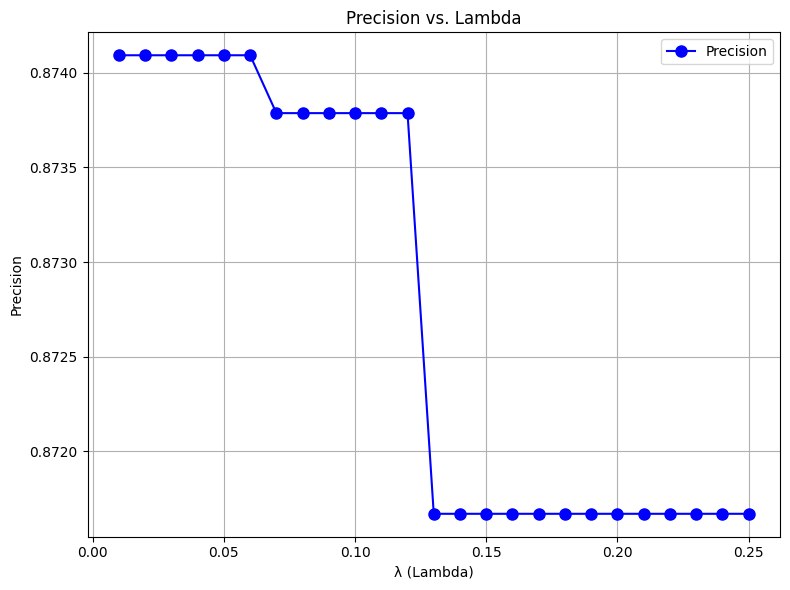

In [13]:
#We search the regularization parameter lambrea in a grid  of data [0,0.5,1,...]
l=0
max_steps=25
l_vec=np.zeros(int(max_steps))
precision=np.zeros(int(max_steps))
for i in range(max_steps):
    l=l+0.01
    l_vec[i]=l
    wR = model.generate_canonicalRidge_estimator(X_e, y_est,l)
    y_hatR = model.estimate_cannonicalRidge(X_e, wR)
    precision[i]=model.precision(y_est, y_hatR)
    

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(l_vec, precision, marker='o', linestyle='-', color='b', markersize=8, label='Precision')
plt.xlabel('λ (Lambda)')
plt.ylabel('Precision')
plt.title('Precision vs. Lambda')
plt.grid(True)  # Add a grid
plt.legend(loc='best')  # Show the legend




# Save or display the plot
plt.tight_layout()  # Ensures labels are not cut off
plt.savefig('precision_vs_lambda.png')  # Save the figure as an image
plt.show()
